In [2]:
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import pickle
import bisect
import numpy as np
import os
from typing import Dict, Any, List
import torch
from transformers import AutoConfig, AutoTokenizer, AutoModel

from data.dataset import BaseDataset

In [3]:
class MyDataset(BaseDataset):
    """
    TODO:
        create your own dataset here.
        Rename the class name and the file name with your student number
    
    Example:
    - 20218078_dataset.py
        @register_dataset("20218078_dataset")
        class MyDataset20218078(BaseDataset):
            (...)
    """

    PRETRAINED_MODEL_NAME_OR_PATH = "emilyalsentzer/Bio_ClinicalBERT"
    MODEL_MAX_LENGTH = 128

    @staticmethod
    def cumsum(sequences):
        r, s = [], 0
        for e in sequences:
            l = len(e)
            r.append(l + s)
            s += l
        return r


    def __init__(
        self,
        data_path: str, # data_path should be a path to the processed features
        **kwargs,
    ):
        super().__init__()
        self.data_path = data_path

        self.mimiciii_path = os.path.join(self.data_path, "mimiciii.pickle")
        self.mimiciv_path  = os.path.join(self.data_path, "mimiciv.pickle")
        self.eicu_path     = os.path.join(self.data_path, "eicu.pickle")

        self.mimiciii = pickle.load(open(self.mimiciii_path, "rb")) if os.path.exists(self.mimiciii_path) else []
        self.mimiciv  = pickle.load(open(self.mimiciv_path, "rb")) if os.path.exists(self.mimiciv_path) else []
        self.eicu     = pickle.load(open(self.eicu_path, "rb")) if os.path.exists(self.eicu_path) else []   
        
        self.raw_datasets = [self.mimiciii, self.mimiciv, self.eicu]
        self.cumulative_sizes = self.cumsum(self.raw_datasets)

        self.tokenizer = AutoTokenizer.from_pretrained(self.PRETRAINED_MODEL_NAME_OR_PATH)

        self.bos_token_id = self.tokenizer.bos_token_id if self.tokenizer.bos_token_id is not None else self.tokenizer.cls_token_id
        self.eos_token_id = self.tokenizer.eos_token_id if self.tokenizer.eos_token_id is not None else self.tokenizer.sep_token_id
        self.sep_token_id = self.tokenizer.sep_token_id
        self.pad_token_id = self.tokenizer.pad_token_id

        self.labs_formats = {
            "mimiciii": "{ITEMID}: {VALUE} {VALUEUOM}",
            "mimiciv": "{itemid}: {value} {valueuom}",
            "eicu": "{labname}: {labresult} {labmeasurename}",
        }
        self.prescrips_formats = {
            "mimiciii": "{DRUG_TYPE} - {DRUG} ({PROD_STRENGTH}): {DOSE_VAL_RX} {DOSE_UNIT_RX}",
            "mimiciv": "{drug_type} - {drug} ({prod_strength}): {dose_val_rx} {dose_unit_rx}",
            "eicu": "{drugname}: {dosage} (frequency: {frequency})",
        }
        self.inputs_formats = {
            "mimiciii": "{ITEMID}: {AMOUNT} {AMOUNTUOM}",
            "mimiciv": "{itemid}: {amount} {amountuom} (rate: {rate} {rateuom})",
            "eicu": "{drugname} - drugrate: {drugrate} infusionrate: {infusionrate} drugamount: {drugamount} volumeoffluid: {volumeoffluid}",
        }

    
    def __getitem__(self, index):
        """
        Note:
            You must return a dictionary here or in collator so that the data loader iterator
            yields samples in the form of python dictionary. For the model inputs, the key should
            match with the argument of the model's forward() method.
            Example:
                class MyDataset(...):
                    ...
                    def __getitem__(self, index):
                        (...)
                        return {"data_key": data, "label": label}
                
                class MyModel(...):
                    ...
                    def forward(self, data_key, **kwargs):
                        (...)
                
        """
        if index < 0:
            if -index > len(self):
                raise ValueError("absolute value of index should not exceed dataset length")
            index = len(self) + index
        dataset_idx = bisect.bisect_right(self.cumulative_sizes, index)
        if dataset_idx == 0:
            sample_idx = index
        else:
            sample_idx = index - self.cumulative_sizes[dataset_idx - 1]
        
        if dataset_idx == 0:
            dataset_name = "mimiciii"
        elif dataset_idx == 1:
            dataset_name = "mimiciv"
        else:
            dataset_name = "eicu"

        return self.preprocess(self.raw_datasets[dataset_idx][sample_idx], dataset_name)
    

    def tokenize(self, items: List[Dict[str, Any]], format_str: str):
        all_input_ids = [self.bos_token_id]
        all_attention_mask = [1]

        for item in items:
            input_str = format_str.format(**item)
            tokenized_inputs = self.tokenizer.encode(input_str, add_special_tokens=False)
            all_input_ids.extend(tokenized_inputs)
            all_attention_mask.extend([1] * len(tokenized_inputs))

            all_input_ids.append(self.sep_token_id)
            all_attention_mask.append(1)
        
        all_input_ids.append(self.eos_token_id)
        all_attention_mask.append(1)

        # PAD or TRUNCATE
        if len(all_input_ids) > self.MODEL_MAX_LENGTH:
            all_input_ids = all_input_ids[:self.MODEL_MAX_LENGTH-1]
            all_input_ids.append(self.eos_token_id)
            all_attention_mask = all_attention_mask[:self.MODEL_MAX_LENGTH]
            
        else:
            all_input_ids.extend([self.pad_token_id] * (self.MODEL_MAX_LENGTH - len(all_input_ids)))
            all_attention_mask.extend([0] * (self.MODEL_MAX_LENGTH - len(all_attention_mask)))

        input_ids = torch.tensor(all_input_ids, dtype=torch.long)
        attention_mask = torch.tensor(all_attention_mask, dtype=torch.long)

        return input_ids, attention_mask
        

    def preprocess(self, sample: Dict[str, Any], dataset_name: str) -> Dict[str, torch.Tensor]:
        """
        Note:
            You can implement this method to preprocess the sample before returning it.
            This method is called in __getitem__ method.
        """
        icustay_id = sample["icustay_id"] if "mimic" in dataset_name else sample["patientunitstayid"]
        label = sample["label"]
        intime = sample["intime"] if "mimic" in dataset_name else ""
        
        events: List[str, Any] = sample["data"]

        all_input_ids = []
        all_attention_mask = []

        if dataset_name in ["mimiciii", "mimiciv"]:
            for event in events:
                if "time" in event:
                    time = event["time"]
                else:
                    time = None

                # Padding is done in the tokenize function
                # Therefore, all the input_ids and attention_mask should have the same length
                if "labs" in event and len(event["labs"]) > 0:
                    input_ids, attention_mask = self.tokenize(event["labs"], self.labs_formats[dataset_name])
                    all_input_ids.append(input_ids)
                    all_attention_mask.append(attention_mask)

                if "prescrips" in event and len(event["prescrips"]) > 0:
                    input_ids, attention_mask = self.tokenize(event["prescrips"], self.prescrips_formats[dataset_name])
                    all_input_ids.append(input_ids)
                    all_attention_mask.append(attention_mask)
                
                if "inputs" in event and len(event["inputs"]) > 0:
                    input_ids, attention_mask = self.tokenize(event["inputs"], self.inputs_formats[dataset_name])
                    all_input_ids.append(input_ids)
                    all_attention_mask.append(attention_mask)
        
        elif dataset_name == "eicu":

            if "labs" in events and len(events["labs"]) > 0:
                input_ids, attention_mask = self.tokenize(events["labs"], self.labs_formats[dataset_name])
                all_input_ids.append(input_ids)
                all_attention_mask.append(attention_mask)

            if "prescrips" in events and len(events["prescrips"]) > 0:
                input_ids, attention_mask = self.tokenize(events["prescrips"], self.prescrips_formats[dataset_name])
                all_input_ids.append(input_ids)
                all_attention_mask.append(attention_mask)
            
            if "inputs" in events and len(events["inputs"]) > 0:
                input_ids, attention_mask = self.tokenize(events["inputs"], self.inputs_formats[dataset_name])
                all_input_ids.append(input_ids)
                all_attention_mask.append(attention_mask)

        return {
            "input_ids": torch.stack(all_input_ids),
            "attention_mask": torch.stack(all_attention_mask),
            "label": label,
            "intime": intime,
            "icustay_id": icustay_id,
        }

    
    def __len__(self):
        return self.cumulative_sizes[-1]

    def collator(self, samples):
        """Merge a list of samples to form a mini-batch.
        
        Args:
            samples (List[dict]): samples to collate
        
        Returns:
            dict: a mini-batch suitable for forwarding with a Model
        
        Note:
            You can use it to make your batch on your own such as outputting padding mask together.
            Otherwise, you don't need to implement this method.
        """

        raise NotImplementedError

In [4]:
dataset = MyDataset("./")

In [4]:
len(dataset)

182997

In [5]:
dataset.cumulative_sizes

[34987, 81146, 182997]

In [6]:
dataset[1]

{'input_ids': tensor([[  101,  1851, 22392,  1604,   131,  1489,  1143,  4426,   120,   181,
            102,  1851,  1604,  1604,  1477,   131,  1572,  1143,  4426,   120,
            181,   102,  1851,  1604,  1580,  1495,   131,   129,   119,   122,
          17713,   120,   173,  1233,   102,  1851, 21500,  1477,   131, 11523,
           1143,  4426,   120,   181,   102,  1851,  1580, 11964,   131,   122,
            119,   123, 17713,   120,   173,  1233,   102,  1851,  1580, 22639,
            131, 16308, 17713,   120,   173,  1233,   102,  1851,  1580, 16480,
            131,   122,   119,   130, 17713,   120,   173,  1233,   102,  1851,
           1580, 20829,   131,   125,   119,   130, 17713,   120,   173,  1233,
            102,  1851,  1580,  1559,  1475,   131,   125,   119,   130,  1143,
           4426,   120,   181,   102,  1851,  1580,  1604,  1495,   131, 17048,
           1143,  4426,   120,   181,   102, 26177,  1568,  1545,   131,  1627,
          17713,   120,   1

In [57]:
dataset[35000]

{'input_ids': tensor([[  101, 15684, 16337,  ..., 16770, 17713,   102],
         [  101, 27445, 26303,  ...,  4426,   120,   102],
         [  101,  2259,   118,  ...,   102,  2259,   102],
         ...,
         [  101,  1851,  1604,  ...,     0,     0,     0],
         [  101, 27445, 26253,  ...,     0,     0,     0],
         [  101,  1514,   118,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'label': '[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2]',
 'intime': '2157-04-01 04:21:49',
 'icustay_id': 3047424}

In [58]:
dataset[100000]

{'input_ids': tensor([[  101,   185,  3069,   131,  1765,   119,   121, 14516,  1665,   102,
          15059,   131, 17048,   119,   121,  2608,  4063,   120,   181,   102,
          21177,   131,   124,   119,   130,  2608,  4063,   120,   181,   102,
           2495,  5822,  2193,   131,   122,   119,   121,  2608,  4063,   120,
            181,   102,   177,  5822,   131,  3236,   119,   122,   110,   102,
            185,  1204,   118,  1107,  1197,   131,   122,   119,   122,  6022,
            102, 21685, 20636,   131,  9920,   119,   121, 17713,   120,   173,
           1233,   102, 21685, 20636,   131, 18030,   119,   121, 17713,   120,
            173,  1233,   102,  4885,  9585,   193,  6087,   131, 11202,   119,
            121,   180,   120,   182,  1665,  1233,   102,   185,  1204,   131,
           1429,   119,   126, 14516,  1665,   102,   172,  1643,  1377,   131,
           3140,   119,   121,  2338,   120,   181,   102,   118,   171,  2225,
           2155,   131,   1

In [32]:
dataset.eicu[0].keys()

dict_keys(['patientunitstayid', 'label', 'data'])

In [18]:
sample = dataset[0]
input_ids = sample['input_ids'].to(device)
attention_mask = sample['attention_mask'].to(device)

outputs = model(input_ids, attention_mask=attention_mask)

In [21]:
outputs['last_hidden_state'].shape, outputs['pooler_output'].shape

(torch.Size([31, 128, 768]), torch.Size([31, 768]))

In [24]:
dataset.tokenizer.decode(input_ids[0], skip_special_tokens=False)

'[CLS] 50868 : 9 meq / l [SEP] 50882 : 24 meq / l [SEP] 50893 : 8. 1 mg / dl [SEP] 50902 : 112 meq / l [SEP] 50912 : 1. 3 mg / dl [SEP] 50931 : 113 mg / dl [SEP] 50960 : 2. 0 mg / dl [SEP] 50970 : 5. 5 mg / dl [SEP] 50971 : 4. 1 meq / l [SEP] 50983 : 141 meq / l [SEP] 51006 : 12 mg / dl [SEP] 5114 [SEP]'

In [8]:
dataset[0]['input_ids'].shape

torch.Size([31, 128])

In [17]:
# hyelin
import random
from tqdm import tqdm

timesteps = []
vec_lengths = []

sample_idx = random.sample(range(len(dataset)), 50000)

for i in tqdm(sample_idx):
    input_ids = dataset[i]['input_ids']
    timesteps.append(input_ids.shape[0])
    vec_lengths.append([torch.count_nonzero(t).item() for t in dataset[0]['input_ids']])


100%|██████████| 50000/50000 [10:22<00:00, 80.31it/s]


(array([3.3887e+04, 8.9990e+03, 4.0660e+03, 1.9590e+03, 8.2700e+02,
        2.0400e+02, 4.5000e+01, 1.0000e+01, 2.0000e+00, 1.0000e+00]),
 array([  1. ,  12.7,  24.4,  36.1,  47.8,  59.5,  71.2,  82.9,  94.6,
        106.3, 118. ]),
 <BarContainer object of 10 artists>)

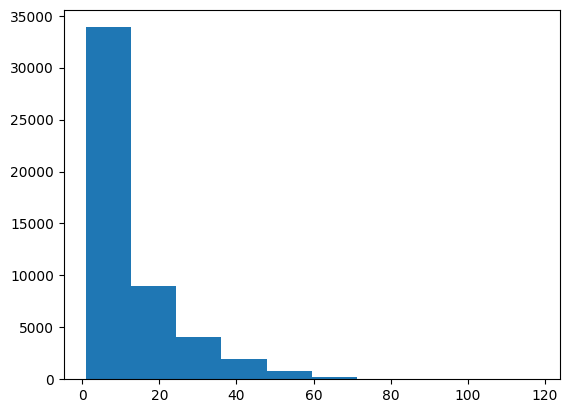

In [20]:
import matplotlib.pyplot as plt

plt.hist(timesteps)

(array([600000., 400000., 150000.,  50000.,  50000., 100000.,      0.,
             0.,      0., 200000.]),
 array([ 11. ,  22.7,  34.4,  46.1,  57.8,  69.5,  81.2,  92.9, 104.6,
        116.3, 128. ]),
 <BarContainer object of 10 artists>)

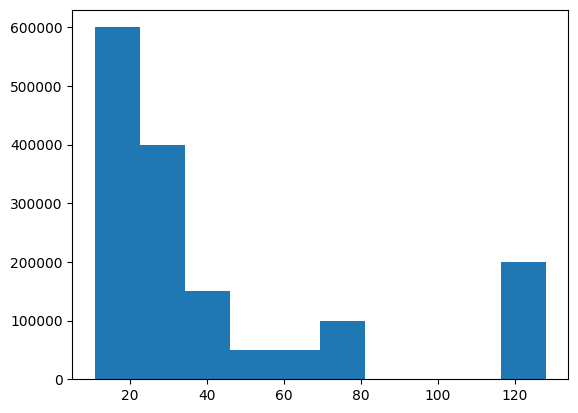

In [23]:
plt.hist([v for v_l in vec_lengths for v in v_l])

In [24]:
dataset[0]

{'input_ids': tensor([[  101,  1851, 22392,  ...,  4062, 17175,   102],
         [  101, 20640, 16229,  ...,     0,     0,     0],
         [  101,  1851, 18910,  ...,     0,     0,     0],
         ...,
         [  101, 22803, 17600,  ...,     0,     0,     0],
         [  101, 21319,  1559,  ...,     0,     0,     0],
         [  101, 20640, 16229,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'label': '[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 4, 2, -1, -1, -1, -1]',
 'intime': '2177-08-29 04:52:21',
 'icustay_id': 3013451}

In [28]:
dataset.mimiciii[0]['data']

[{'time': '2177-08-29 05:09:00',
  'labs': [{'ITEMID': 50868, 'VALUE': '9', 'VALUEUOM': 'mEq/L', 'FLAG': nan},
   {'ITEMID': 50882, 'VALUE': '24', 'VALUEUOM': 'mEq/L', 'FLAG': nan},
   {'ITEMID': 50893, 'VALUE': '8.1', 'VALUEUOM': 'mg/dL', 'FLAG': 'abnormal'},
   {'ITEMID': 50902, 'VALUE': '112', 'VALUEUOM': 'mEq/L', 'FLAG': 'abnormal'},
   {'ITEMID': 50912, 'VALUE': '1.3', 'VALUEUOM': 'mg/dL', 'FLAG': 'abnormal'},
   {'ITEMID': 50931, 'VALUE': '113', 'VALUEUOM': 'mg/dL', 'FLAG': 'abnormal'},
   {'ITEMID': 50960, 'VALUE': '2.0', 'VALUEUOM': 'mg/dL', 'FLAG': nan},
   {'ITEMID': 50970, 'VALUE': '5.5', 'VALUEUOM': 'mg/dL', 'FLAG': 'abnormal'},
   {'ITEMID': 50971, 'VALUE': '4.1', 'VALUEUOM': 'mEq/L', 'FLAG': nan},
   {'ITEMID': 50983, 'VALUE': '141', 'VALUEUOM': 'mEq/L', 'FLAG': nan},
   {'ITEMID': 51006, 'VALUE': '12', 'VALUEUOM': 'mg/dL', 'FLAG': nan},
   {'ITEMID': 51143, 'VALUE': '0', 'VALUEUOM': '%', 'FLAG': nan},
   {'ITEMID': 51144, 'VALUE': '6', 'VALUEUOM': '%', 'FLAG': 'abnormal'

In [29]:
m3[0]

{'icustay_id': 3013451,
 'label': '[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 4, 2, -1, -1, -1, -1]',
 'intime': '2177-08-29 04:52:21',
 'data': [{'time': '2177-08-29 05:09:00',
   'labs': [{'SUBJECT_ID': 1012739,
     'HADM_ID': 2013275,
     'ITEMID': 'Anion Gap',
     'CHARTTIME': '2177-08-29 05:09:00',
     'VALUE': '9',
     'VALUENUM': 9.0,
     'VALUEUOM': 'mEq/L',
     'FLAG': nan,
     'ICUSTAY_ID': 3013451},
    {'SUBJECT_ID': 1012739,
     'HADM_ID': 2013275,
     'ITEMID': 'Bicarbonate',
     'CHARTTIME': '2177-08-29 05:09:00',
     'VALUE': '24',
     'VALUENUM': 24.0,
     'VALUEUOM': 'mEq/L',
     'FLAG': nan,
     'ICUSTAY_ID': 3013451},
    {'SUBJECT_ID': 1012739,
     'HADM_ID': 2013275,
     'ITEMID': 'Calcium, Total',
     'CHARTTIME': '2177-08-29 05:09:00',
     'VALUE': '8.1',
     'VALUENUM': 8.1,
     'VALUEUOM': 'mg/dL',
     'FLAG': 'abnormal',
     'ICUSTAY_ID': 3013451},
    {'SUBJECT_ID': 1012739,
     'HADM_ID': 2013275,
     'ITEMI

In [30]:
dataset.mimiciii_path

'./mimiciii.pickle'